# HW_06 : Нейросети в обработке текста. 
> Рекуррентные нейронные сети. LSTM. GRU.

Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

DATA_PATH = '../data/отзывы за лето.xls'

<b>Настройка GPU</b>

In [31]:
import tensorflow as tf
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [32]:
# глобальные переменнные для предобработки
max_words = 2000
max_len = 40

In [33]:
df = pd.read_excel(DATA_PATH, parse_dates=[2])
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


### Бинарная классификация

In [34]:
df_bin = df[df['Rating']!=3]

In [35]:
df_bin['Target'] = (df['Rating']>3).astype('uint8')

In [36]:
# распределение не очень, но рабочее
df_bin.Target.value_counts(normalize=True)

1    0.846871
0    0.153129
Name: Target, dtype: float64

#### Препроцессинг

In [37]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [38]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_bin['Content'] = df_bin['Content'].apply(preprocess_text)

In [39]:
# разобьем датасет на трайн-валид-тест 70-15-15
train, test = train_test_split(df_bin, test_size=0.7, shuffle=True, stratify = df_bin['Target'], random_state=42)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

In [40]:
train_corpus = " ".join(train["Content"])
train_corpus = train_corpus.lower()

In [41]:
tokens = word_tokenize(train_corpus)
tokens_filtered = [word for word in tokens if word.isalnum()]

In [42]:
# наиболее часто встречающиеся токены
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [43]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [44]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [45]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["Content"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in valid["Content"]], dtype=np.int32)

In [46]:
y_train = train["Target"]
y_test = test["Target"]
y_valid = valid["Target"]

In [47]:
x_train[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 648,  19, 122, 190, 959, 959,
       959], dtype=int32)

### Модели

In [48]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN , LSTM, GRU, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping 

In [49]:
epochs = 50
batch_size = 512

In [50]:
rnn_type = ['R', 'L', 'G']

In [51]:
def plot_metrics(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [52]:
def make_rnn_layer(param):
    if param == 'R':
        layer = SimpleRNN(128)
        print('\n=== SimpleRNN ===\n')
    elif param == 'L':
        layer = LSTM(128, recurrent_dropout=0.4)
        print('\n=== LSTM ===\n')
    elif param == 'G':
        layer = GRU(128, recurrent_dropout=0.4)
        print('\n=== GRU ===\n')    
    else:
        raise Exception('make_layer(param) -> param have to be in("R", "L", "G")')
    return layer 

In [53]:
def make_model(param : str) -> object:
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=max_len, input_length=max_len, trainable=True, mask_zero=True))
    model.add(Masking(mask_value=0.0))
    model.add(make_rnn_layer(param))
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [54]:
def fit_model(model):
    if not model:
        return
    model.summary()
    
    tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)  

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[tensorboard, early_stopping])
    return history
    

In [55]:
def test_model(model):
    
    score = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=1)
    print('\n')
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    results = model.predict(x_test, batch_size=batch_size, verbose=1)
    print(f'Test ROC-AUC: {round(roc_auc_score(y_test, results),3)}')
    print('\n'*3)
    print('=='*30)


=== SimpleRNN ===

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_3 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               21632     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None

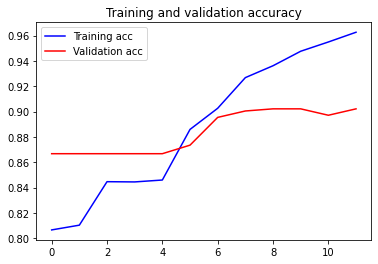

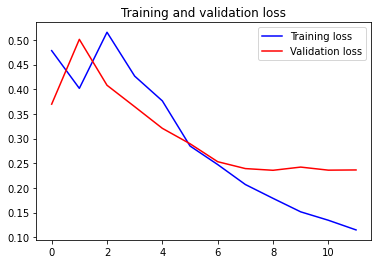

14/14 [==============================] - 0s 4ms/step - loss: 0.2416 - accuracy: 0.9018


Validation loss: 0.24156147241592407
Validation accuracy: 0.9017650485038757
14/14 [==============================] - 0s 3ms/step
Test ROC-AUC: 0.938





=== LSTM ===

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_4 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               86528     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0    

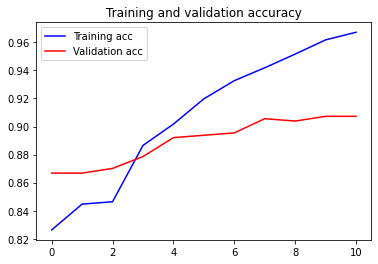

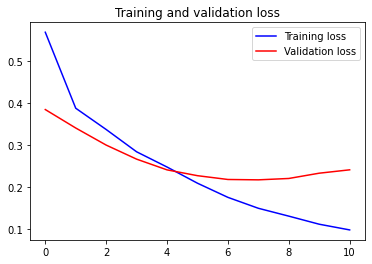

14/14 [==============================] - 0s 10ms/step - loss: 0.2347 - accuracy: 0.9015


Validation loss: 0.23467673361301422
Validation accuracy: 0.9014756679534912
14/14 [==============================] - 0s 10ms/step
Test ROC-AUC: 0.943





=== GRU ===

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 40)            80000     
_________________________________________________________________
masking_5 (Masking)          (None, 40, 40)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               65280     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0   

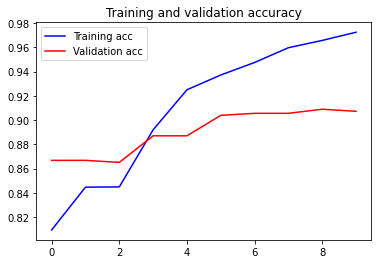

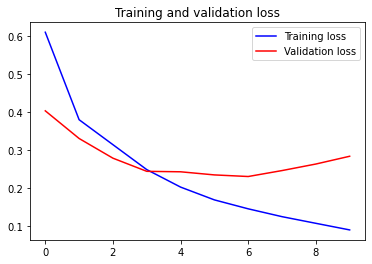

14/14 [==============================] - 0s 8ms/step - loss: 0.2531 - accuracy: 0.8935


Validation loss: 0.2530638575553894
Validation accuracy: 0.8935185074806213
14/14 [==============================] - 0s 8ms/step
Test ROC-AUC: 0.936






In [56]:
for param in rnn_type:
    model = make_model(param)
    hist = fit_model(model)
    plot_metrics(hist)
    test_model(model)

### Выводы

Лучший результат показал LSTM, 2 место досталось SimpleRNN и на последнем GRU - при одинаковых параметрах сети. Стоит отметить что даже лучший результат LSTM оказался ниже чем результат CNN сети из прошлой темы.

Видимо для каждой сети нужно подбирать индивидуальные настройки и конфигурацию.